# Pattern Lattice Builder (PLB) runner

developed by Kow Kuroda (kow.kuroda@gmail.com)

created on 2024/10/18

modified on 2024/10/20, 21, 22, 23, 26, 27

modifications
1. add compatibility with package format (2024/10/20)
2. implemented automatic figure sizing (2024/10/22)
3. implemented robust z-score (2024/10/23)
4. implemetend multiprocess-based speeding up 

In [1]:
## imports
import gPLB as plb

## The following needs to be True only for debugging/development.
re_import_module = True
if re_import_module:
    import importlib
    importlib.reload (plb)

In [2]:
## inspect plb.py
import pprint as pp
content_check = False
if content_check:
    pp.pprint(dir(plb))

In [3]:
## select target file
import csv
data_dir = "data"
data_names = [  'plb-inteY-max9', 'plb-inteY-max11',
                'plb-utau-naku-sinu', 'plb-utau-naku-sinu-commented',
                'plb-XiY-max7', 'plb-XiY-max9', 'plb-XiY-wiper2-phonetic', 'plb-XiY-wiper2b', 'plb-XiY-wiper3-dual','plb-XiY-wiper5b-dual'
            ]

data_name = data_names[0]
data_file = f"{data_dir}/{data_name}.csv"
print(f"read data from: {data_file}")

read data from: data/plb-inteY-max9.csv


In [4]:
## Parameters
## managemental
verbose     = True

## set font for Japanese character display
use_multibyte_chars = True

## internal variables
comment_escape = '#'
field_sep      = r","

## size filtering on input
size_filtering  = True
max_size        = 6

## parameters for PLB
gap_marks      = [ "…", "_" ]
gap_mark       = gap_marks[0]

## if instantiation check is reflexive
reflexive      = True

## if Generalized Pattern Lattice is used nor not
generalized    = True

## if robust Z-score is used instead of normal Z-score
use_robust_zscores   = False

## select the bases of z-scores: link sources or link targets
zscores_from_sources = True

### settings for drawing
## full display for merged pattern lattice
draw_full_version_for_merged = False

In [5]:
## set up font
import matplotlib
from matplotlib import font_manager as Font_manager

if use_multibyte_chars:
    ## select font
    multibyte_font_names = [    "IPAexGothic",  # 0 Multi-platform font
                                "Hiragino sans" # 1 Mac only
                            ]
    multibyte_font_name  = multibyte_font_names[0]
    ## tell where target fonts are
    system_font_dir = "/System/Library/Fonts/"
    user_font_dir = "/Library/Fonts/"
    # use the version installed via TeXLive
    user_font_dir2 = "/usr/local/texlive/2013/texmf-dist/fonts/truetype/public/ipaex/"
    if multibyte_font_name == "IPAexGothic":
        try:
            Font_manager.fontManager.addfont(f"{user_font_dir}ipaexg.ttf")
        except FileNotFoundError:
            Font_manager.fontManager.addfont(f"{user_font_dir2}ipaexg.ttf")
    elif multibyte_font_name == "Hiragino sans":
        Font_manager.fontManager.addfont(f"{system_font_dir}ヒラギノ角ゴシック W0.ttc")
    ## check result
    matplotlib.rc('font', family = multibyte_font_name)
else:
    multibyte_font_name = None
    matplotlib.rcParams['font.family'] = "Sans-serif"
##
print(f"multibyte_font_name: {multibyte_font_name}")
print(f"matplotlib.rcParams['font.family']: {matplotlib.rcParams['font.family']}")    

multibyte_font_name: IPAexGothic
matplotlib.rcParams['font.family']: ['IPAexGothic']


# Preparation

In [6]:
## graph layout selection
graph_layouts = [   'Multi_partite', # 0
                    'Graphviz', # 1
                    'Spring', # 2
                    'Planar', # 3
                    'Circular', # 4
                    'Shell', # 5
                    'Spectral', # 6
                    'Kamada_Kawai', # 7
                    'Fruchterman_Reingold', # 8
                    'ARF', # 9
                    'Breadth-First Search', # 10
                 ]
#
graph_layout = graph_layouts[0]
print(f"graph_layout: {graph_layout}")

graph_layout: Multi_partite


In [7]:
## reading data
with open(data_file, encoding = "utf-8") as file:
    data = list(csv.reader(file, delimiter = field_sep)) # Crucially list(..)

## discard comment lines that start with #
data = [ F for F in data if len(F) > 0 and not F[0][0] == comment_escape ]

## strip extra spaces
data = [ [ f.strip() for f in F ] for F in data ]

## remove in-line comments
data_renewed = [ ]
for F in data:
    G = []
    for f in F:
        pos = f.find(comment_escape)
        if pos > 0:
            G.append(f[:pos])
            continue
        else:
            G.append(f)
    ##
    data_renewed.append(G)
##
data = data_renewed

In [8]:
## check result
import pprint as pp
pp.pprint(data)

[['i', 'n', 't', 'e', 'r', 'n', 'a', 'l'],
 ['a', 'c', 't'],
 ['a', 'c', 't', 'u', 'a', 'l'],
 ['f', 'a', 'c', 't'],
 ['f', 'a', 'c', 't', 'u', 'a', 'l'],
 ['f', 'a', 'c', 't', 'i', 'v', 'e'],
 ['i', 'n', 't', 'e', 'r', 'a', 'c', 't'],
 ['i', 'n', 't', 'e', 'l', 'l', 'e', 'c', 't'],
 ['a', 'c', 't', 'i', 'v', 'e'],
 ['n', 'e', 'g', 'l', 'e', 'c', 't'],
 ['i', 'n', 'f', 'l', 'e', 'c', 't'],
 ['c', 'o', 'l', 'l', 'e', 'c', 't'],
 ['i', 'n', 't', 'e', 'r', 'n']]


# Process individual pattern lattices

In [9]:
## size filter
if size_filtering:
    data = [ x for x in data if len(x) <= max_size ]

In [10]:
## sampling
sampling = True
sampling_rate = 0.75
if sampling:
      import random
      data = random.sample(data, round(len(data) * sampling_rate))
##
pp.pprint(data)

[['a', 'c', 't', 'i', 'v', 'e'],
 ['a', 'c', 't', 'u', 'a', 'l'],
 ['a', 'c', 't'],
 ['f', 'a', 'c', 't']]


In [11]:
## build pattern lattices from data
Lx = [ ]
for item in data:
    pat    = plb.Pattern(item, gap_mark)
    patlat = plb.PatternLattice(pat, reflexive = reflexive, generalized = generalized)
    if verbose:
            print(patlat)
    Lx.append(patlat)

#instantiate ['…', '…', '…', '…', '…', '…'] to ['a', '…', '…', '…', '…', '…']
#instantiate ['…', '…', '…', '…', '…', '…'] to ['…', 'c', '…', '…', '…', '…']
#instantiate ['…', '…', '…', '…', '…', '…'] to ['…', '…', 't', '…', '…', '…']
#instantiate ['…', '…', '…', '…', '…', '…'] to ['…', '…', '…', 'i', '…', '…']
#instantiate ['…', '…', '…', '…', '…', '…'] to ['…', '…', '…', '…', 'v', '…']
#instantiate ['…', '…', '…', '…', '…', '…'] to ['…', '…', '…', '…', '…', 'e']
#instantiate ['…', '…', '…', '…', '…', '…', '…'] to ['…', '…', '…', '…', '…', '…']
#instantiate ['…', '…', '…', '…', '…', '…', '…'] to ['a', '…', '…', '…', '…', '…', '…']
#instantiate ['…', '…', '…', '…', '…', '…', '…'] to ['…', 'a', '…', '…', '…', '…', '…']
#instantiate ['…', '…', '…', '…', '…', '…', '…'] to ['…', 'c', '…', '…', '…', '…', '…']
#instantiate ['…', '…', '…', '…', '…', '…', '…'] to ['…', '…', 'c', '…', '…', '…', '…']
#instantiate ['…', '…', '…', '…', '…', '…', '…'] to ['…', '…', 't', '…', '…', '…', '…']
#instanti

Unknown layout: Multi-partite (default) is used
#fig_size_local: (18.0, 16.0)
#font_size: 8
#node_size: 12


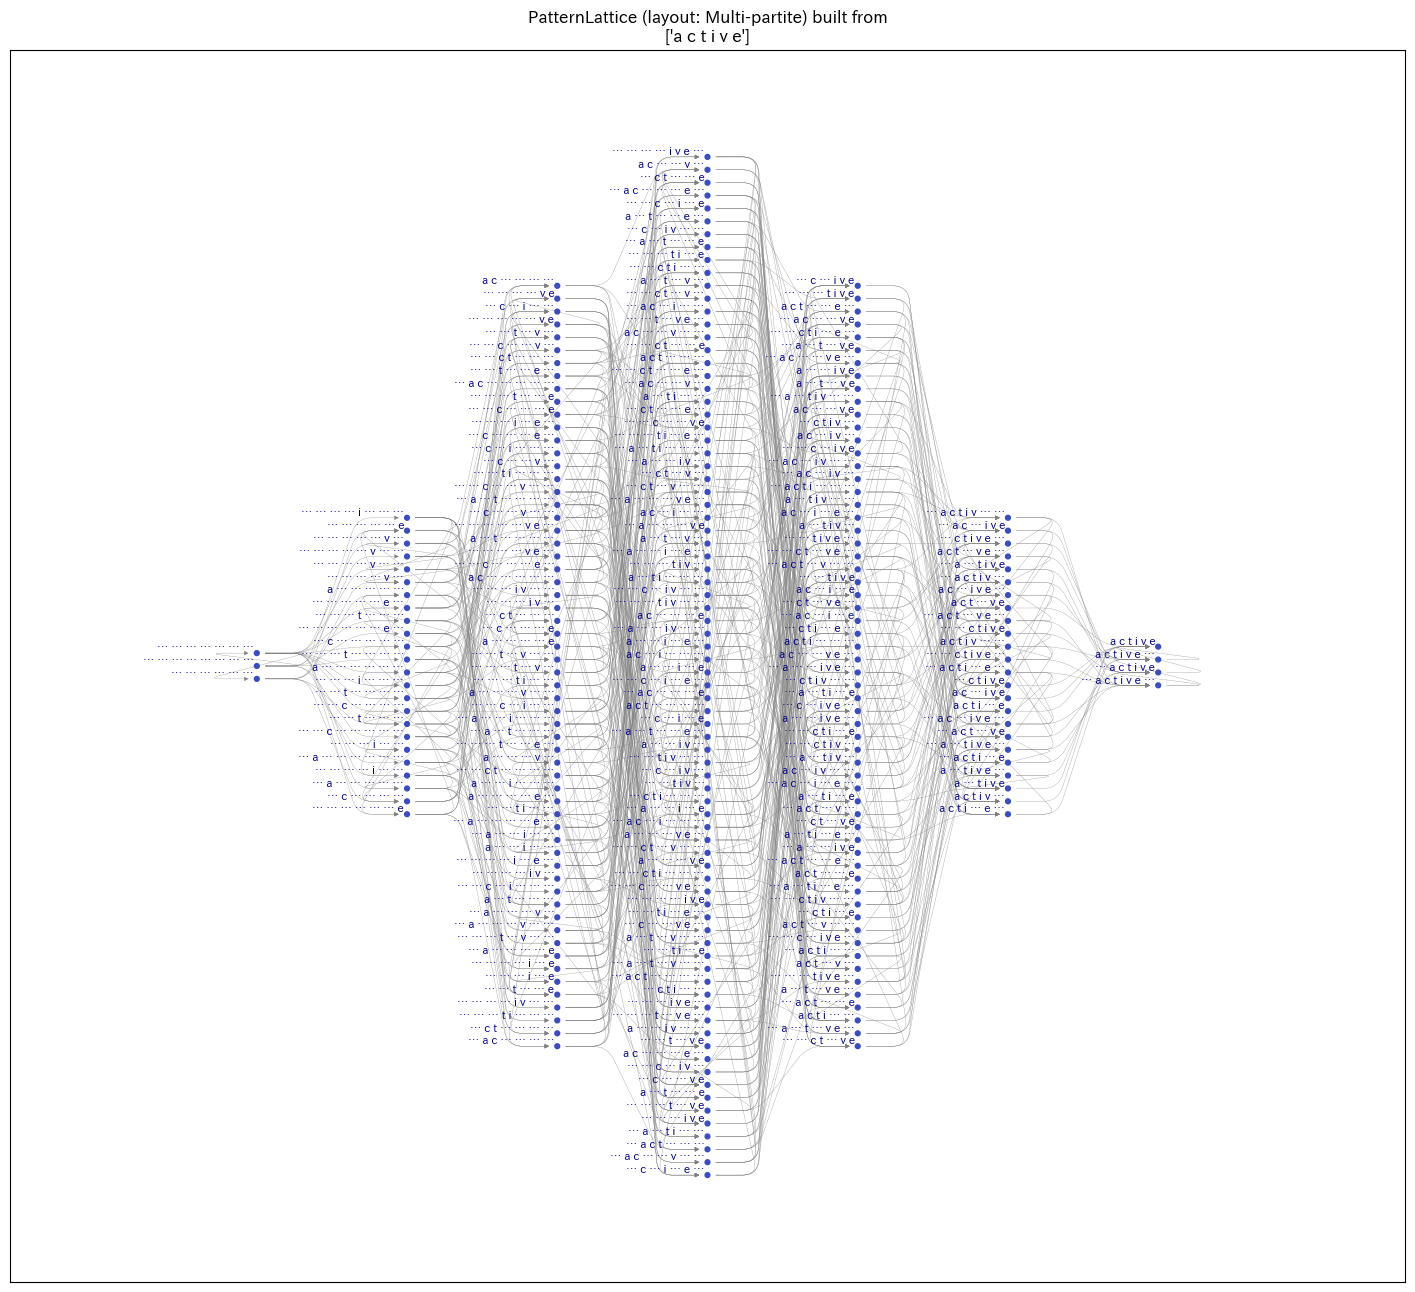

Unknown layout: Multi-partite (default) is used
#fig_size_local: (18.0, 16.0)
#font_size: 8
#node_size: 12


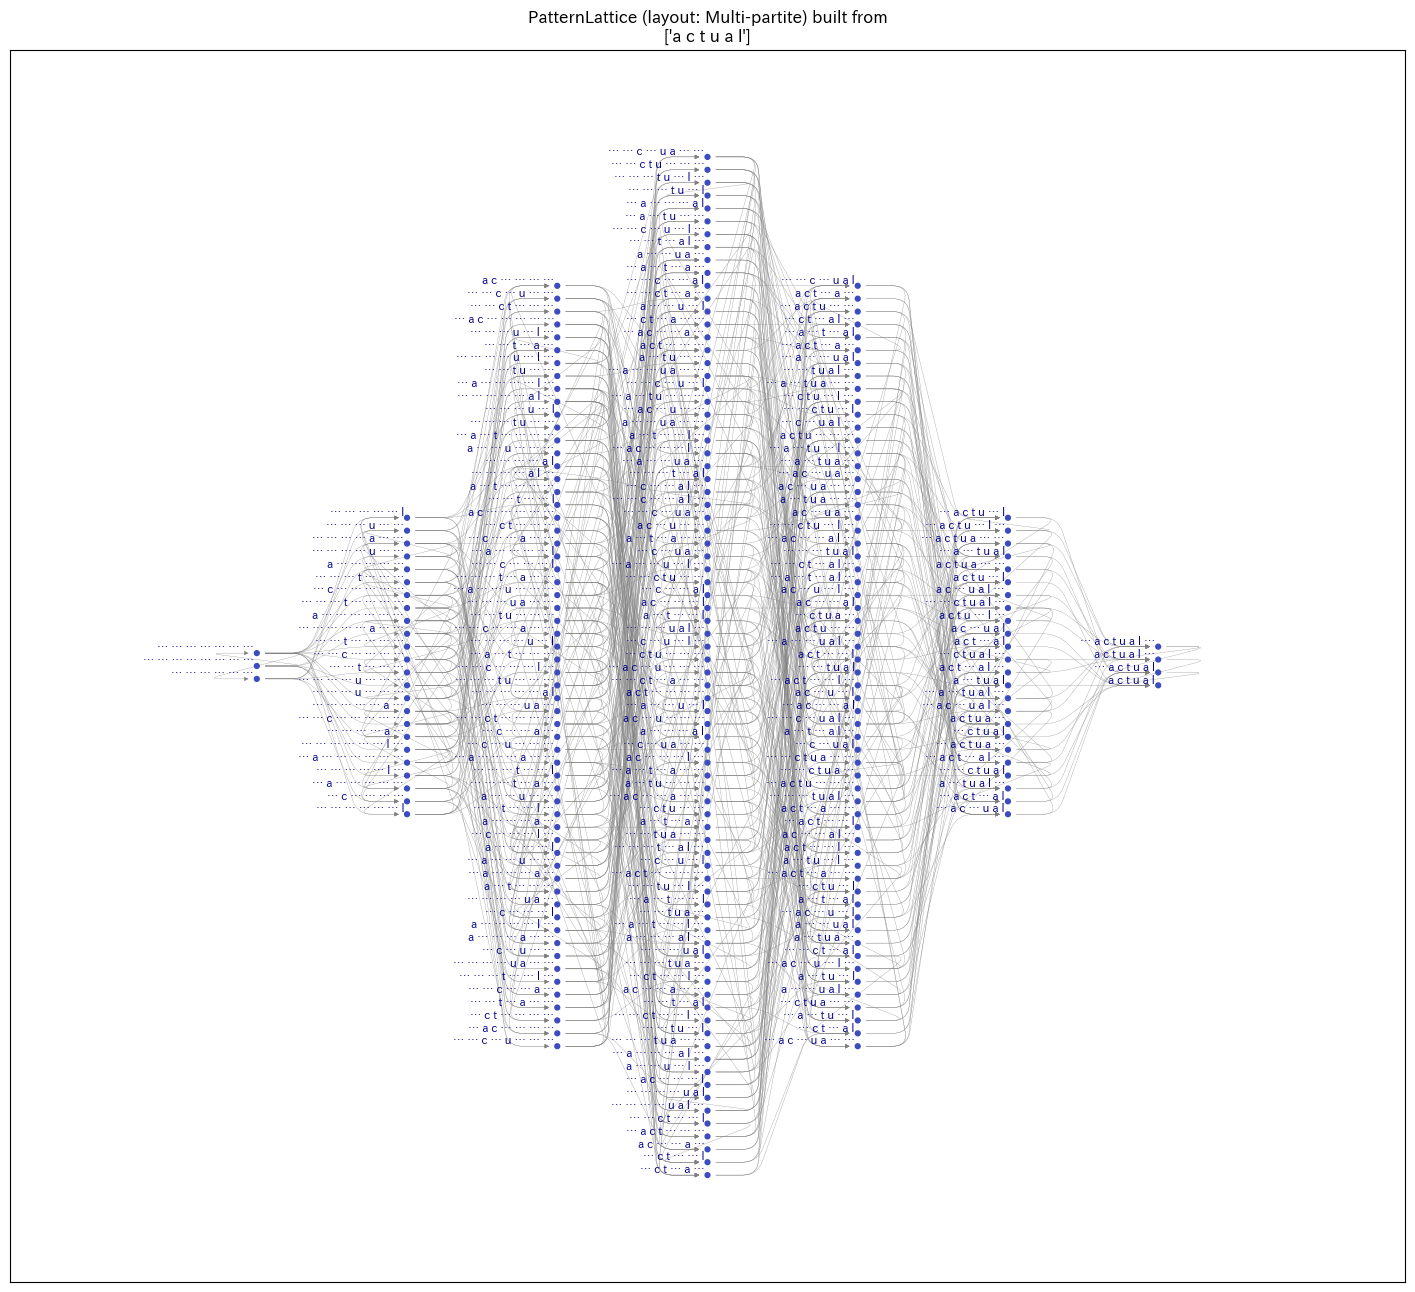

Unknown layout: Multi-partite (default) is used
#fig_size_local: (10.0, 2.0)
#font_size: 8
#node_size: 12


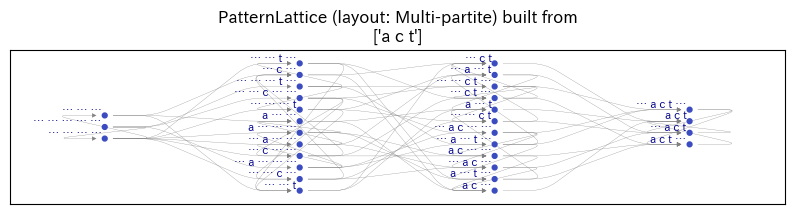

Unknown layout: Multi-partite (default) is used
#fig_size_local: (12.0, 5.0)
#font_size: 8
#node_size: 12


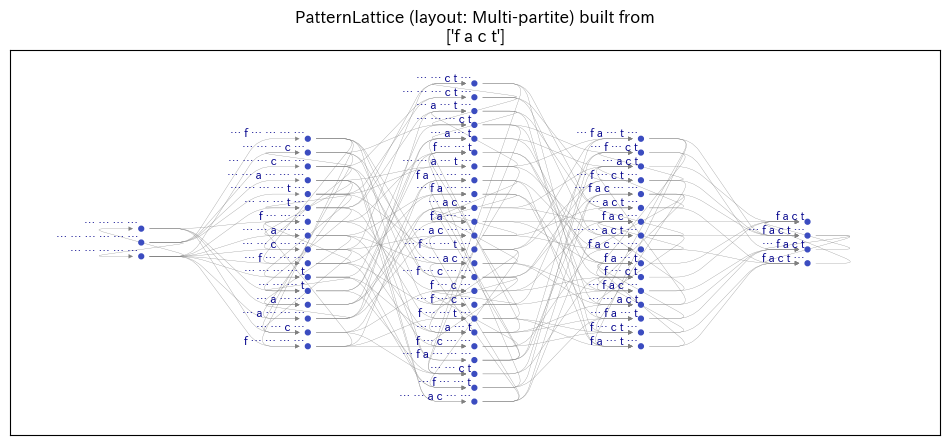

In [12]:
## draw pattern lattices individually
for patlat in Lx:
    patlat.draw_diagrams (font_name = multibyte_font_name, auto_fig_sizing = True)

In [13]:
#raise "Stop execution"

# Process merged pattern lattice

In [ ]:
## merge pattern lattices
import functools
M = functools.reduce (lambda La, Lb: La.merge_lattices (Lb,
                                                        gen_links = True, reflexive = reflexive, show_steps = True,
                                                        check = True),
                                                        Lx)

# The following process was isolated for speeding up
if len(M.links) == 0:
    M.update_links (reflexive = reflexive)

#pooled_nodes [0]: [Pattern ([('a', ['a']), ('c', ['c']), ('t', ['t']), ('i', ['i']), ('v', ['v']), ('e', ['e'])]), Pattern ([('a', ['a']), ('c', ['c']), ('t', ['t']), ('i', ['i']), ('v', ['v']), ('e', ['e']), ('…', ['#'])]), Pattern ([('a', ['a']), ('c', ['c']), ('t', ['t']), ('i', ['i']), ('v', ['v']), ('…', ['e'])]), Pattern ([('a', ['a']), ('c', ['c']), ('t', ['t']), ('i', ['i']), ('v', ['v']), ('…', ['e']), ('…', ['#'])]), Pattern ([('a', ['a']), ('c', ['c']), ('t', ['t']), ('i', ['i']), ('…', ['v']), ('e', ['e'])]), Pattern ([('a', ['a']), ('c', ['c']), ('t', ['t']), ('i', ['i']), ('…', ['v']), ('e', ['e']), ('…', ['#'])]), Pattern ([('a', ['a']), ('c', ['c']), ('t', ['t']), ('i', ['i']), ('…', ['v']), ('…', ['e'])]), Pattern ([('a', ['a']), ('c', ['c']), ('t', ['t']), ('i', ['i']), ('…', ['v']), ('…', ['e']), ('…', ['#'])]), Pattern ([('a', ['a']), ('c', ['c']), ('t', ['t']), ('…', ['i']), ('v', ['v']), ('e', ['e'])]), Pattern ([('a', ['a']), ('c', ['c']), ('t', ['t']), ('…', ['

In [62]:
## calculate z-scores from link sources
if verbose:
    print(f"##Link_sources")
    
Link_sources     = M.link_sources
averages_by_rank = plb.calc_averages_by_rank (Link_sources, gap_mark) # returns dictionary
stdevs_by_rank   = plb.calc_stdevs_by_rank (Link_sources, gap_mark) # returns dictionary
medians_by_rank  = plb.calc_medians_by_rank (Link_sources, gap_mark) # returns dictionary
MADs_by_rank     = plb.calc_MADs_by_rank (Link_sources, gap_mark) # returns dictionary

## calculate z-scores
source_zscores = { }
robust_zscores_from_s   = [ ] # for inspection only
normal_zscores_from_s   = [ ] # for inspection only
for i, link_source in enumerate(Link_sources):
    rank     = plb.get_rank_of_list (link_source, gap_mark)
    value    = M.link_sources[link_source]
    ## robust z-scores
    robust_zscore  = plb.calc_zscore (value,
                                      averages_by_rank[rank], stdevs_by_rank[rank], medians_by_rank[rank], MADs_by_rank[rank], robust = True)
    robust_zscores_from_s.append(robust_zscore)
    ## normal z-scores
    normal_zscore   = plb.calc_zscore_old (value, averages_by_rank[rank], stdevs_by_rank[rank])
    normal_zscores_from_s.append(normal_zscore)

    if use_robust_zscores:
        source_zscores[link_source] = robust_zscore
    else:
        source_zscores[link_source] = normal_zscore
    if verbose:
        print(f"#source {i}: {link_source} has {value} out-going(s) [{source_zscores[link_source]: .4f} at rank {rank}]")
    
## attach source_zscores to M
M.source_zscores.update(source_zscores)

##Link_sources
#source 0: ('…', '…', '…', '…', '…') has 1 out-going(s) [ 0.0000 at rank 0]
#source 1: ('…', '…', '…', '…', '…', '…') has 1 out-going(s) [ 0.0000 at rank 0]
#source 2: ('…', '…', '…', '…', '歌う') has 1 out-going(s) [-0.5300 at rank 1]
#source 3: ('…', '…', '…', 'で', '…') has 1 out-going(s) [-0.5300 at rank 1]
#source 4: ('…', '…', '中', '…', '…') has 1 out-going(s) [-0.5300 at rank 1]
#source 5: ('…', 'の', '…', '…', '…') has 1 out-going(s) [-0.5300 at rank 1]
#source 6: ('風呂', '…', '…', '…', '…') has 1 out-going(s) [-0.5300 at rank 1]
#source 7: ('…', '…', '…', '…', '歌う', '…') has 1 out-going(s) [-0.5300 at rank 1]
#source 8: ('…', '…', '…', 'で', '…', '…') has 1 out-going(s) [-0.5300 at rank 1]
#source 9: ('…', '…', '中', '…', '…', '…') has 1 out-going(s) [-0.5300 at rank 1]
#source 10: ('…', 'の', '…', '…', '…', '…') has 1 out-going(s) [-0.5300 at rank 1]
#source 11: ('風呂', '…', '…', '…', '…', '…') has 5 out-going(s) [ 2.0140 at rank 1]
#source 12: ('…', '…', '…', '…', '…',

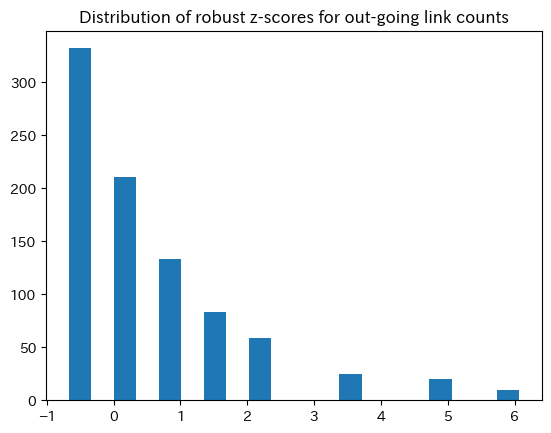

In [63]:
## check robust z-score distribution
import matplotlib.pyplot as plt
plt.hist(robust_zscores_from_s, bins = 20)
plt.title(f"Distribution of robust z-scores for out-going link counts")
plt.show()

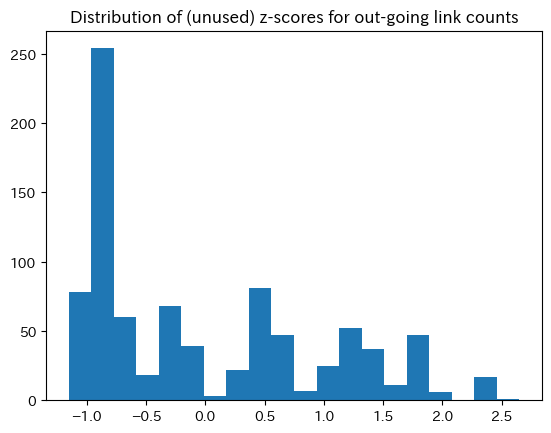

In [64]:
## check robust z-score distribution
import matplotlib.pyplot as plt
plt.hist(normal_zscores_from_s, bins = 20)
plt.title(f"Distribution of (unused) z-scores for out-going link counts")
plt.show()

In [65]:
## Calculate z-scores from link targets
if verbose:
    print(f"##Link_targets")

Link_targets     = M.link_targets
averages_by_rank = plb.calc_averages_by_rank (Link_targets, gap_mark) # returns dictionary
stdevs_by_rank   = plb.calc_stdevs_by_rank (Link_targets, gap_mark) # returns dictionary
medians_by_rank  = plb.calc_medians_by_rank (Link_targets, gap_mark) # returns dictionary
MADs_by_rank     = plb.calc_MADs_by_rank (Link_targets, gap_mark) # returns dictionary

## calculate z-scores
target_zscores = { }
robust_zscores_from_t  = [ ] # for inspection only
normal_zscores_from_t  = [ ] # for inspection only
for i, link_target in enumerate(Link_targets):
    rank     = plb.get_rank_of_list (link_target, gap_mark)
    value    = Link_targets[link_source]
    ## robust z-scores
    robust_zscore  = plb.calc_zscore (value,
                                      averages_by_rank[rank], stdevs_by_rank[rank], medians_by_rank[rank], MADs_by_rank[rank], robust = True)
    robust_zscores_from_t.append(robust_zscore)
    ## tracking z-scores
    normal_zscore   = plb.calc_zscore_old (value,
                                           averages_by_rank[rank], stdevs_by_rank[rank])
    normal_zscores_from_t.append(normal_zscore)
    if use_robust_zscores:
        target_zscores[link_target] = robust_zscore
    else:
        target_zscores[link_target] = normal_zscore
    if verbose:
        print(f"#target {i}: {link_target} has {value} in-coming(s) [{target_zscores[link_target]: .4f} at rank {rank}]")

## attach source_zscores to M
M.target_zscores.update(target_zscores)

##Link_targets
#target 0: ('…', '…', '…', '…', '歌う') has 8 in-coming(s) [ 14.1421 at rank 1]
#target 1: ('…', '…', '…', 'で', '…') has 8 in-coming(s) [ 14.1421 at rank 1]
#target 2: ('…', '…', '中', '…', '…') has 8 in-coming(s) [ 14.1421 at rank 1]
#target 3: ('…', 'の', '…', '…', '…') has 8 in-coming(s) [ 14.1421 at rank 1]
#target 4: ('風呂', '…', '…', '…', '…') has 8 in-coming(s) [ 14.1421 at rank 1]
#target 5: ('雨', '…', '…', '…', '…') has 8 in-coming(s) [ 14.1421 at rank 1]
#target 6: ('…', '…', '…', '…', '…') has 8 in-coming(s) [ 0.0000 at rank 0]
#target 7: ('…', '…', '…', '…', '歌う', '…') has 8 in-coming(s) [ 14.1421 at rank 1]
#target 8: ('…', '…', '…', 'で', '…', '…') has 8 in-coming(s) [ 14.1421 at rank 1]
#target 9: ('…', '…', '中', '…', '…', '…') has 8 in-coming(s) [ 14.1421 at rank 1]
#target 10: ('…', 'の', '…', '…', '…', '…') has 8 in-coming(s) [ 14.1421 at rank 1]
#target 11: ('風呂', '…', '…', '…', '…', '…') has 8 in-coming(s) [ 14.1421 at rank 1]
#target 12: ('…', '…', '…', '…'

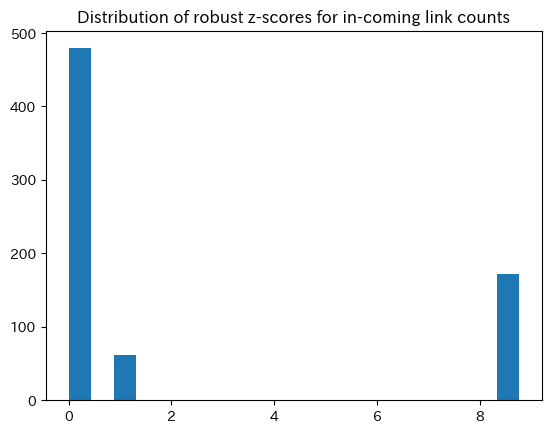

In [66]:
## check z-score distribution
import matplotlib.pyplot as plt
plt.hist(robust_zscores_from_t, bins = 20)
plt.title(f"Distribution of robust z-scores for in-coming link counts")
plt.show()

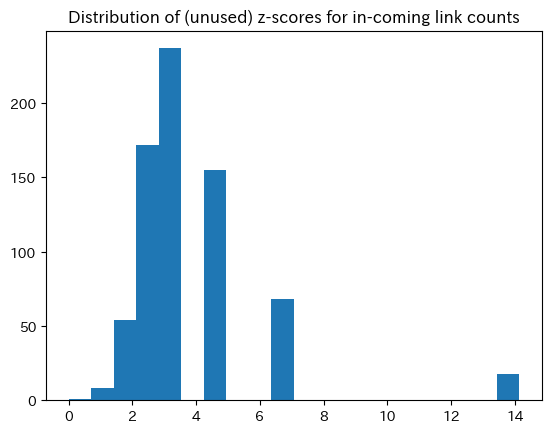

In [67]:
## check z-score distribution
import matplotlib.pyplot as plt
plt.hist(normal_zscores_from_t, bins = 20)
plt.title(f"Distribution of (unused) z-scores for in-coming link counts")
plt.show()

In [68]:
## select z-score base
#get_zscores_from_sources = True
if zscores_from_sources:
    Link_bases = M.source_zscores
else:
    Link_bases = M.target_zscores
## check result
i = 0
for key, value in Link_bases.items():
    i += 1
    print(f"node {i:4d} {key} has z-score: {value: .4f}")

node    1 ('…', '…', '…', '…', '…') has z-score:  0.0000
node    2 ('…', '…', '…', '…', '…', '…') has z-score:  0.0000
node    3 ('…', '…', '…', '…', '歌う') has z-score: -0.5300
node    4 ('…', '…', '…', 'で', '…') has z-score: -0.5300
node    5 ('…', '…', '中', '…', '…') has z-score: -0.5300
node    6 ('…', 'の', '…', '…', '…') has z-score: -0.5300
node    7 ('風呂', '…', '…', '…', '…') has z-score: -0.5300
node    8 ('…', '…', '…', '…', '歌う', '…') has z-score: -0.5300
node    9 ('…', '…', '…', 'で', '…', '…') has z-score: -0.5300
node   10 ('…', '…', '中', '…', '…', '…') has z-score: -0.5300
node   11 ('…', 'の', '…', '…', '…', '…') has z-score: -0.5300
node   12 ('風呂', '…', '…', '…', '…', '…') has z-score:  2.0140
node   13 ('…', '…', '…', '…', '…', '歌う') has z-score: -0.5300
node   14 ('…', '…', '…', '…', '…', '歌う', '…') has z-score: -0.5300
node   15 ('…', '…', '…', '…', 'で', '…') has z-score: -0.5300
node   16 ('…', '…', '…', '…', 'で', '…', '…') has z-score: -0.5300
node   17 ('…', '…', '

#pruning nodes with z-score less than 0
#pruning ('…', '…', '…', '…', '歌う', '…') with z-score -0.529999
#pruning ('…', '…', '…', 'で', '…', '…') with z-score -0.529999
#pruning ('…', '…', '中', '…', '…', '…') with z-score -0.529999
#pruning ('…', 'の', '…', '…', '…', '…') with z-score -0.529999
#pruning ('…', '…', '…', '…', '…', '歌う') with z-score -0.529999
#pruning ('…', '…', '…', '…', '…', '歌う', '…') with z-score -0.529999
#pruning ('…', '…', '…', '…', 'で', '…') with z-score -0.529999
#pruning ('…', '…', '…', '…', 'で', '…', '…') with z-score -0.529999
#pruning ('…', '…', '…', '中', '…', '…') with z-score -0.529999
#pruning ('…', '…', '…', '中', '…', '…', '…') with z-score -0.529999
#pruning ('…', '…', 'の', '…', '…', '…') with z-score -0.529999
#pruning ('…', '…', 'の', '…', '…', '…', '…') with z-score -0.529999
#pruning ('…', '風呂', '…', '…', '…', '…') with z-score -0.529999
#pruning ('…', '…', '…', '…', '歌う') with z-score -0.529999
#pruning ('…', '…', '…', 'で', '…') with z-score -0.529999


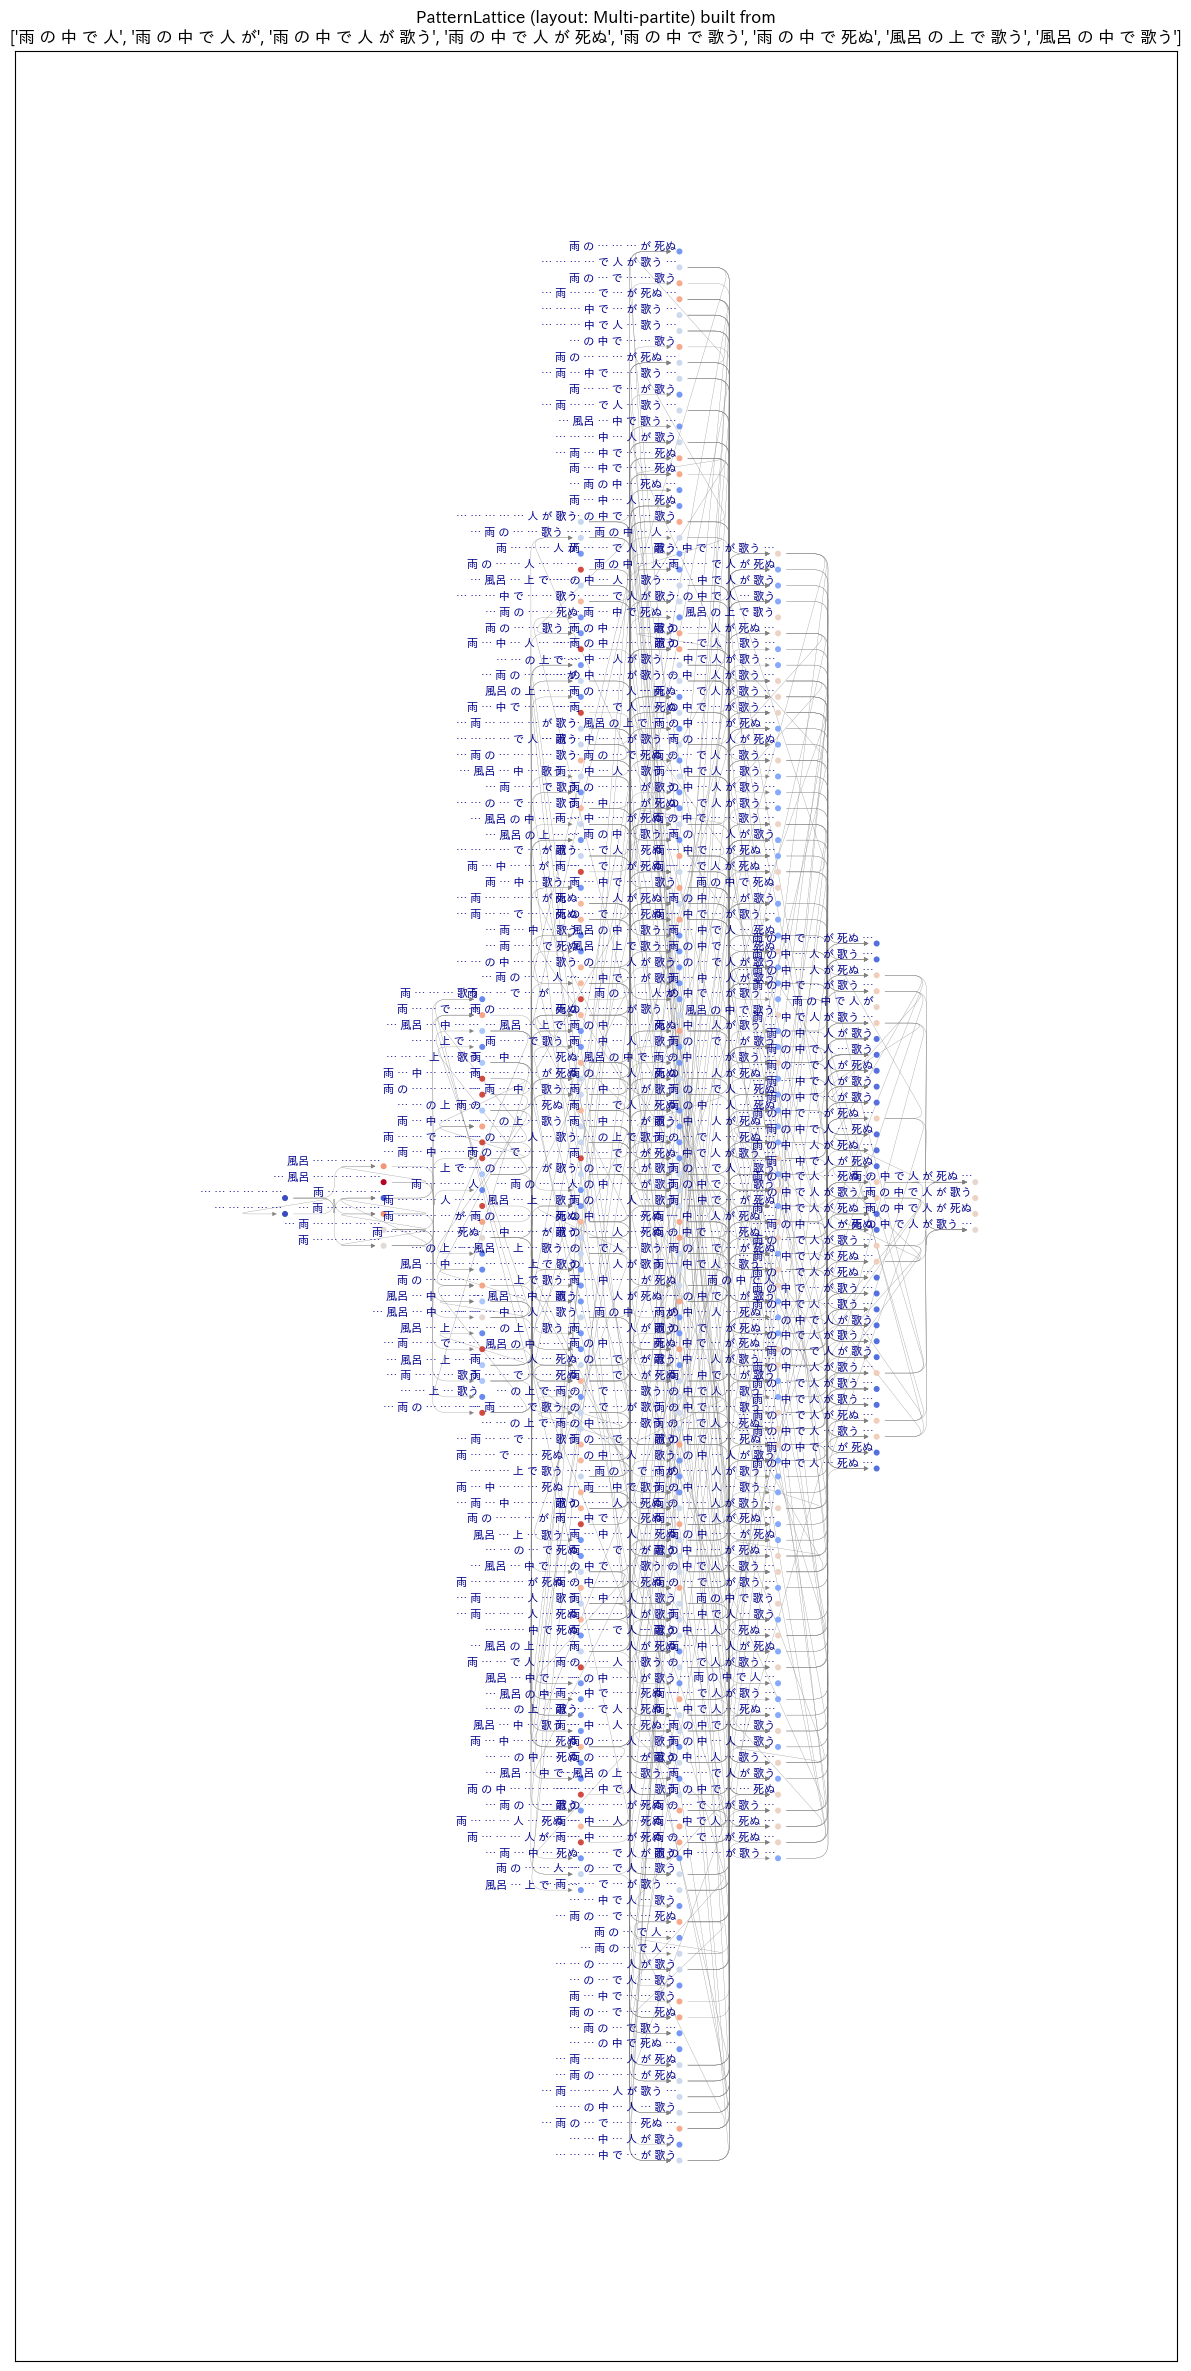

In [69]:
## draw a pruned diagram from the merged lattice
graph_layouts = [   'Multi_partite', # 0
                    'Graphviz', # 1
                    'Spring', # 2
                    'Planar', # 3
                    'Circular', # 4
                    'Shell', # 5
                    'Spectral', # 6
                    'Kamada_Kawai', # 7
                    'Fruchterman_Reingold', # 8
                    'ARF', # 9
                    'Breadth-First Search', # 10
                 ]
##
layout             = graph_layouts[0]
scale_factor       = 3
zscore_lowerbound  = 0

manually_set = True
if manually_set:
   M.draw_diagrams (layout = layout, auto_fig_sizing = False, fig_size = (15, 30),
                    label_sample_n = 4, label_size = 16, node_size = 52,
                    font_name = multibyte_font_name, zscore_lowerbound = zscore_lowerbound,
                    scale_factor = scale_factor, check = False)
else:
   M.draw_diagrams (layout = layout, auto_fig_sizing = True, label_sample_n = 4,
                    zscore_lowerbound = zscore_lowerbound,
                    scale_factor = scale_factor, font_name = multibyte_font_name, check = False)

In [70]:
## draw a full diagram from the merged lattice
if draw_full_version_for_merged:
    layout = graph_layouts[0]
    zscore_lowerbound  = None
    scale_factor       = 3
    ##
    adjusted = False
    if adjusted:
        M.draw_diagrams (layout = layout, zscore_lowerbound = zscore_lowerbound,
        scale_factor = scale_factor, fig_size = (24, 60), label_size = 12, node_size = 33, font_name = multibyte_font_name, check = False)
    else:
        M.draw_diagrams (layout = layout, zscore_lowerbound = zscore_lowerbound,
        scale_factor = scale_factor, font_name = multibyte_font_name, check = False)